# COMP3721 - Introduction to Music Processing - Practical
## High-level representations in the audio domain

Eamonn Bell  
<eamonn.bell@durham.ac.uk>

2024-11-14 (rev. 1)

By the end of this practical you should able to:

- use the Short-Time Fourier Transform (STFT) to produce log-spaced spectrograms
- use the STFT to produce chromagram feature representations
- understand how chromagram feature sequences can be normalised
- explore the effects of different normalisation approaches on a simple framing of a chroma-detection task


This notebook is for non-commercial use only, and freely adapts material from:

- Meinard Müller and Sebastian Rosenzweig: PCP Notebooks: A Preparation Course for Python with a Focus on Signal Processing. The Journal of Open Source Education (JOSE), 5(47), 2022. [[site]](https://www.audiolabs-erlangen.de/resources/MIR/PCP/PCP.html) (MIT License)
- Meinard Müller: Fundamentals of Music Processing – Using Python and Jupyter Notebooks. 2nd edition, Springer Verlag, 2021. [[notebooks]](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html) (Code: MIT License, Text and figures: CC BY-NC-SA 4.0 DEED)


In [3]:
import os
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
import librosa
import pandas as pd
import IPython.display as ipd

import libfmp.c2
from libfmp.c3 import f_pitch

%matplotlib inline

Recall that we can load in an audio file into an array (with some sample rate `Fs`), which is its time-domain representation...

In [4]:
Fs = 22050
x, Fs = librosa.load('FMP_C3_F03.wav', sr=Fs)

...and we can produce a power spectrogram with the help of the STFT. Instead of using the `librosa` implementation or your implementation from last time, we use one from the FMP text reference, for consistency with what follows. The arguments have their usual meaning; the return values are:

- `X` spectrogram
- `T_coef` time axis, in seconds
- `F_coef` frequency axis, in Hz

(In case you are interested more of the differences between this implementation of the STFT and others, you can read more online)

In [5]:
N = 4096
H = 1024
X, T_coef, F_coef = libfmp.c2.stft_convention_fmp(x, Fs, N, H)
Y = np.abs(X) ** 2

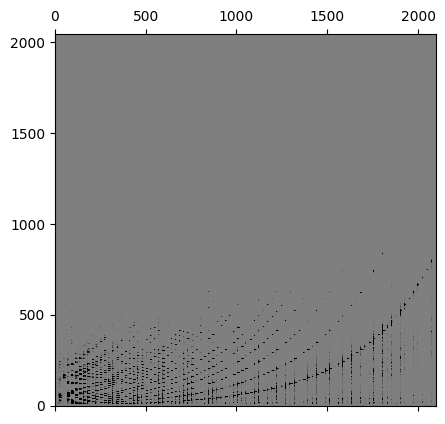

In [6]:
plt.matshow(Y, origin='lower', aspect='auto', cmap='gray_r')
plt.clim([-30, 30])

# 1 Log-frequency spectrogram


As before, $x$ is a real-valued discrete signal obtained by equidistant sampling with respect to a fixed sampling rate $F_\mathrm{s}$ given in Hertz. Furthermore, let $\mathcal{X}$ be the discrete STFT with respect to a window $w$ of length $N\in\mathbb{N}$ and hop size $H\in\mathbb{N}$. 

By applying zero-padding, we can assume that the Fourier coefficients $\mathcal{X}(n,k)$ are indexed by frame parameters $n\in\mathbb{Z}$ and frequency parameters $k\in[0:K]$, where $K=N/2$. Recall that each Fourier coefficient $\mathcal{X}(n,k)$ is associated with the  time position $T_\mathrm{coef}(n) = nH/F_\mathrm{s}$ given in seconds and with the frequency 

\begin{equation}
F_\mathrm{coef}(k) = \frac{k \cdot F_\mathrm{s}}{N}.
\end{equation}

We see above the results of analysing a chromatic scale played on a piano starting with the note A0 ($p=21$) and ending  with C8 ($p=108$). The resulting spectrogram reveals the exponential dependency of the fundamental frequency on the pitches of the played notes. In the following, the chromatic scale will serve as one of our running examples. 

The basic idea here is to develop an improved presentation of the data from the STFT, which better reflects the perception of pitch.
We will redefine the frequency axis to correspond to the logarithmically spaced frequency distribution of the equal-tempered scale.

## 1.1 Pooling pitches

The basic idea is to assign each spectral coefficient $\mathcal{X}(n,k)$ to the pitch with a center frequency that is closest to the frequency $F_\mathrm{coef}(k)$. More precisely, we define for each pitch $p\in[0:127]$ the set

\begin{equation}
    P(p) := \{k:F_\mathrm{pitch}(p-0.5) \leq   F_\mathrm{coef}(k) <  F_\mathrm{pitch}(p+0.5)\}.
\end{equation}

Given a pitch, expressed as a MIDI note number, a sample rate, and other relevant information, write a function `pool_pitch` that computes the set of frequency indices that are assigned to a given pitch.

You will want to return a set of indices into the array that is the column of a spectrogram. If $p = 79$, say, then `pool_pitch` might return `array([ 93,  94,  95,  96])`, meaning that components `93` through `96` are those that contain the energy relevant to that note.

 We like to work with indices stored as `numpy` arrays here, because it allows us to subset array data more easily later on.

In [ ]:
def pool_pitch(p, Fs, N, pitch_ref=69, freq_ref=440.0):
    """Computes the set of frequency indices that are assigned to a given pitch

    Args:
        p (float): MIDI pitch value
        Fs (scalar): Sampling rate
        N (int): Window size of Fourier fransform
        pitch_ref (float): Reference pitch in MIDI note numbers (default: 69)
        freq_ref (float): Frequency of reference pitch (default: 440.0)

    Returns:
        p_f_indices (np.ndarray): Set of frequency indices
    """
    lower = f_pitch(p - 0.5, pitch_ref, freq_ref)
    upper = f_pitch(p + 0.5, pitch_ref, freq_ref)
    
    k = np.arange(N // 2 + 1)
    k_freq = k * Fs / N
    
    mask = np.logical_and(lower <= k_freq, k_freq < upper)
    p_f_indices = k[mask]
    return p_f_indices

In [8]:
assert(np.all(np.equal(pool_pitch(72, Fs=22050, N=4096), np.array([ 95,  96,  97,  98,  99, 100]))))

## 1.2 Log-frequency spectrogram


Based on the sets $P(p)$, we obtain a log-frequency spectrogram $\mathcal{Y}_\mathrm{LF}:\mathbb{Z}\times [0:127]$ using a simple pooling procedure:

\begin{equation}
      \mathcal{Y}_\mathrm{LF}(n,p) := \sum_{k \in P(p)}{|\mathcal{X}(n,k)|^2}.
\end{equation}

By this procedure, the frequency axis is partitioned logarithmically and labeled linearly according to MIDI pitches. 

The following code should produce the resulting log-frequency spectrogram, where the played notes of the chromatic scale now appear in a linearly increasing fashion.

In [7]:
def compute_spec_log_freq(Y, Fs, N):
    """Computes a log-frequency spectrogram

    Args:
        Y (np.ndarray): Magnitude or power spectrogram
        Fs (scalar): Sampling rate
        N (int): Window size of Fourier fransform

    Returns:
        Y_LF (np.ndarray): Log-frequency spectrogram, pitch as MIDI note 
            numbers in x axis
        F_coef_pitch (np.ndarray): Pitch values in MIDI note numbers
    """
    Y_LF = np.zeros((128, Y.shape[1]))
    for p in range(128):
        k = pool_pitch(p, Fs, N) # HINT: You can import from libfmp.c3 if you do not have a solution for pool_pitch
        Y_LF[p, :] = Y[k, :].sum(axis=0)

    F_coef_pitch = np.arange(128)
    return Y_LF, F_coef_pitch

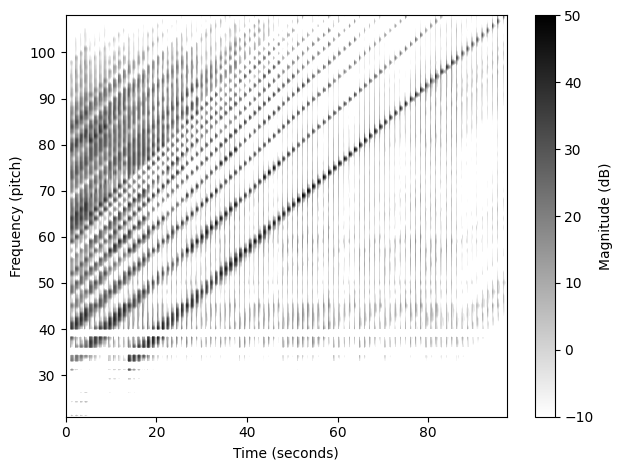

In [8]:
Y_LF, _ = compute_spec_log_freq(Y, Fs, N)        

EPSILON = 1e-10
plt.imshow(10 * np.log10(EPSILON + Y_LF), origin='lower', aspect='auto', cmap='gray_r', 
           extent=[T_coef[0], T_coef[-1], 0, 127])
plt.clim([-10, 50])
plt.ylim([21, 108])
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (pitch)')
cbar = plt.colorbar()
cbar.set_label('Magnitude (dB)')

plt.tight_layout()

There are some remarks echoing what was discussed briefly in lecture. As a general trend, the sounds for higher notes possess a cleaner harmonic spectrum than the ones for lower notes. For lower notes, the signal's energy is often contained in the higher harmonics, while the listener may still have the perception of a low-pitched sound. This is related to the phenomenon of the "missing fundamental".

The vertical stripes (along the frequency axis) shown by the spectrogram indicate that some of the signal's energy is spread over large parts of the spectrum. The main reason for the energy spread is due to the inharmonicities of the piano sound caused by the keystroke (mechanical noise) and other effects.

Furthermore, the frequency content of recorded sound depends on the microphone's frequency response. For example, the microphone may capture only frequencies above a certain threshold. This also may explain why there is virtually no energy visible in the fundamental frequencies for the notes A0 ($p=21$) to B0 ($p=32$).

There is another reason for the rather poor representation of low pitches when using the pooling strategy based on a discrete STFT. While the discrete STFT introduces a **linear** sampling of the frequency axis, the bandwidth used in the pooling strategy depends on the frequency in a **logarithmic** fashion. 

As a result, the set $P(p)$ may contain only very few spectral coefficients or may even be empty for small values of $p$ (which is the reason for the horizontal white stripes in the figure above).

## 1.3 Producing a chromagram from a log-frequency spectrogram

We now discuss a strategy to increase the robustness of the log-frequency spectrogram to variations in timbre and instrumentation. The main idea is to combine pitch bands corresponding to pitches that differ by one or several octaves, sinc the human perception of pitch is periodic in the sense that two pitches are perceived as similar if they differ by an octave. 

Based on this observation, a pitch can be separated into two components, the octave number and the chroma (which is the letter part of the pitch name) contained in the set:

$$
\{\mathrm{C},\mathrm{C}^\sharp,\mathrm{D},\mathrm{D}^\sharp,\ldots,\mathrm{B}\}.
$$

(Here note that $\mathrm{C}^\sharp$ is equivalent to $\mathrm{D}^\flat$, since 12-tone equal temperament is in operatoon. You will soon develop an intuition for why these two alternative names for "the same thing" exists, but not yet).

Enumerating the chroma values, we identify this set with $[0:11]$ where $0$ refers to chroma $\mathrm{C}$, $1$ to $\mathrm{C}^\sharp$, and so on. A **pitch class** is more formally defined as the set of all pitches that share the same chroma (it is in fact an equivalence class). For example, the pitch class corresponding to the chroma  $\mathrm{C}$ is the set  $\{\ldots,\,\mathrm{C0},\mathrm{C1},\mathrm{C2},\mathrm{C3},\ldots\}$ consisting of all pitches separated by an integer number of octaves. For simplicity, we use the terms chroma and pitch class interchangeably.

The main idea of **chroma features** is to aggregate all spectral information that relates to a given pitch class into a single coefficient. Given a pitch-based log-frequency spectrogram $\mathcal{Y}_\mathrm{LF}:\mathbb{Z}\times[0:127]\to \mathbb{R}_{\geq 0}$, a **chroma representation** or **chromagram** $\mathbb{Z}\times[0:11]\to \mathbb{R}_{\geq 0}$ can be derived by summing up all pitch coefficients that belong to the same chroma:

\begin{equation}
      \mathcal{C}(n,c) := \sum_{\{p \in [0:127]\,:\,p\,\mathrm{mod}\,12 = c\}}{\mathcal{Y}_\mathrm{LF}(n,p)}
\end{equation}

for $c\in[0:11]$. 


Complete the implementation of `compute_chromagram` below, which is suitable for producing a chromagram of the chromatic scale, given a log-frequency spectrogram.

Because of the octave equivalence, the increasing notes of the chromatic scale should become "wrapped around" the chroma axis. 



In [9]:
def compute_chromagram(Y_LF):
    """Computes a chromagram

    Args:
        Y_LF (np.ndarray): Log-frequency spectrogram

    Returns:
        C (np.ndarray): Chromagram
    """
    C = np.zeros((12, Y_LF.shape[1]))
    p = np.arange(128)
    for c in range(12):
        mask = (p % 12) == c
        C[c, :] = Y_LF[mask, :].sum(axis=0)
    return C

As with the log-frequency spectrogram, the resulting chromagram of the considered audio example is rather noisy, in particular for the lower notes. Furthermore, because of the presence of higher harmonics, the energy is typically spread across various chroma bands even when playing a single note at a time. For example, playing the note C3, the third harmonic corresponds to G4 and the fifth harmonic to E5.  Therefore, when playing the note C3 on the piano, not only the chroma band $\mathrm{C}$, but also the chroma bands $\mathrm{G}$ and $\mathrm{E}$ contain a substantial portion of the signal's energy.

Despite this, we can still use the chromagram to extract features that can be used to inform a simple approach to detecting the most probable chroma being played at a given frame in an audio recording, which we look to now.

## 2 A template-matching approach to chroma detection

Our goal is to produce a judgment about what is the chroma of the note being played at a given moment of a short recording of a piano. Given an audio recording, the first step is to transform the recording into a sequence $X=(x_1,x_2,\ldots,x_N)$ of feature vectors $x_n\in\mathcal{F}$, $n\in[1:N]$, where $\mathcal{F}$ denotes a suitable feature space. Classical procedures to reason about pitch and chroma rely on some type of **chroma-based feature representation**, because chroma-based features capture a signal's short-time tonal content. Assuming the equal-tempered scale, the chroma values correspond to the set $\{\mathrm{C},\mathrm{C}^\sharp,\mathrm{D},\ldots,\mathrm{B}\}$, which we identify with the set $[0:11]$. A chroma feature can then be expressed as a $12$-dimensional vector 

$$
x=(x(0),x(1),\ldots,x(11))^\top\in\mathcal{F}=\mathbb{R}^{12}
$$ 

Let's consider the overall picture first. Some sequence of chroma features $X=(x_1,x_2,\ldots,x_N)$ and a set $\Lambda$ of possible chord labels, the objective is to map each chroma vector $x_n\in\mathbb{R}^{12}$ to a chroma label $\lambda_{n} \in \Lambda$, $n\in[1:N]$. For example, one may consider the set

\begin{equation}
  \Lambda = \{\mathrm{C},\mathrm{C}^\sharp,\mathrm{D},\mathrm{D}^\sharp,\ldots,\mathrm{B}\}
\end{equation}

consisting of the twelve chroma or pitch-class names. In this case, each frame $n\in[1:N]$ is assigned to a single chroma $\lambda_{n}$. 

For the pattern-matching step, we now introduce a simple template-based approach. The idea is to precompute a set 

$$
\mathcal{T}\subset\mathcal{F}=\mathbb{R}^{12}
$$ 

of templates denoted by $\mathbf{t}_\lambda\in\mathcal{T}$, $\lambda\in\Lambda$. Intuitively, each template can be thought of as a prototypical chroma vector that represents a chroma. (Spoiler: The chroma templates will be one-hot vectors of length 12.)

Furthermore, we fix a similarity measure $s$ that allows for comparing different chroma vectors. Then, the template-based procedure consists in assigning the chord label that maximizes the similarity between the corresponding template and the given feature vector $x_n$:

\begin{equation}
        \lambda_{n} := \underset{\lambda \in \Lambda}{\mathrm{argmax}}
         \,\, s( \mathbf{t}_\lambda , x_n ).
\end{equation}

Concretely, this goes as follows: for the chord label set $\Lambda$, we choose the twelve major and twelve minor triads. For example, in the case of chroma $\mathrm{F}^\sharp$ the resulting chroma vector is

\begin{equation}
    \mathbf{t}_{\mathrm{F}^\sharp}{} := x =(0,0,0,0,0,0,1,0,0,0,0,0)^\top.
\end{equation}

Using a chroma-based encoding, all the twelve templates needed to cover the chromagram can be obtained by repeatedly cyclically shifting the binary vector for $\mathrm{C}$  (or indeed, any chroma). 

For comparing chroma features and chord templates, we use in the following a simple similarity measure using the inner product of normalized vectors:

\begin{equation}
  s(x,y)= \frac{\langle x,y\rangle}{\|x\|\cdot\|y\|}
\end{equation}

for $x,y\in\mathcal{F}$ with  $\|x\|\not= 0$ and $\|y\|\not= 0$. Recall that the inner product of two real-valued vectors can be written as $\langle x,y\rangle = \textbf{x}^{T}\textbf{y}$. By extension, if we have two matrixes $\textbf{X}$ (e.g. filled with chromagram features), and $\textbf{Y}$ (e.g. filled with templates), we can fill a third matrix $\textbf{Z}$ with the similiarity results with $\textbf{Y}^{T}\textbf{X}$.

In [10]:
def generate_templates():
    """Generates chroma templates
    
    Returns:
        chroma_templates (np.ndarray): Chroma templates
    """
    templates = list()
    
    base = np.zeros(shape=(12))
    base[[0]] = 1

    for i in range(12):
        templates.append(np.roll(base, i))

    chroma_templates = np.array(templates)
    return chroma_templates
        

Next, we generate some pseudo-ground truth that we can use as labels to test the effectiveness of our approach. The way I generate this is relatively special-purpose, since in this case we know that the only sounds in the clip are the piano keys in succession. I know that the first pitch in the recording is A0. I can use a `librosa` utility to detect the onsets of each note (not in scope for this module) and then just cycle through the chroma - after all, I know the notes being played differ by exactly a semitone each time. 

The only slight subtlety is that our chroma identification produces its "predictions" in frames (why?), whereas I get samples from `librosa`'s onset detection implementation. So, I need to ensure the labels are framewise, for direct comparison with our own results.

In [11]:
def generate_pseudo_ground_truth(Fs=22050, N=4096, H=1024):
    """
    Generate a pseudo ground truth matrix for chroma detection.

    Args:
        Fs (int): Sampling rate of the audio signal.
        N (int): Window size for the analysis. 
        H (int): Hop length for the analysis.

    Returns:
        pseudo_ground_truth (np.ndarray): 
            Array in which each column corresponds to the true
              chroma vector for one frame
    """
    Fs = Fs
    x, Fs = librosa.load('FMP_C3_F03.wav', sr=Fs)
    onsets = librosa.onset.onset_detect(y=x, sr=Fs, units='samples')
    
    onsets_frames = np.floor(onsets / H).astype(int)    
    num_frames = int(np.ceil(len(x) / H))
    
    GT = np.zeros((12, num_frames))

    # We know that the recording starts at A0...
    start = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
    
    # ...and has 88 notes in it
    num_notes = len(onsets)
    for i in range(num_notes):
        begin = onsets_frames[i]

        if i == num_notes - 1:
            end = num_frames
        else:
            end = onsets_frames[i + 1]

        GT[:, begin:end] = np.roll(start, shift=i % 12).reshape(-1, 1)
    
    pseudo_ground_truth = GT
    return pseudo_ground_truth

In the following code cell, we provide an implementation for the template-based  recognition procedure described before.

First, the audio recording is converted into a chroma representation. As an example, we use the STFT-variant as computed before. 

Second, each chroma vector is compared with each of the $12$ binary chroma templates, which yields $12$ similarity values per frame. We keep these but do not plot them.

Third, we select for each frame the chroma label $\lambda_{n}$ of the template that maximizes the similarity value over all $12$ choices of chroma template. This yields our final recognition result, which is can be thought of as a  **binary time-chroma representation**.


In [12]:
def chroma_recognition_template(C, norm_sim='1', norm_C='2', norm_templates='2'):
    """Conducts template-based chroma recognition

    Args:
        C (np.ndarray): Chromagram
        norm_sim (str): Specifies norm used for normalizing chroma similarity matrix (Default value = '1')
        norm_C (str): Specifies norm used for normalizing chromagram (Default value = '2')
        norm_templates (str): Specifies norm used for normalizing chroma templates (Default value = '2')


    Returns:
        chroma_sim (np.ndarray): Chroma similarity matrix
        chroma_max (np.ndarray): Binarized chroma similarity matrix only containing maximizing chroma
    """

    C_norm = libfmp.c3.normalize_feature_sequence(C, norm=norm_C)
    
    chroma_templates = generate_templates()
    chroma_templates_norm = libfmp.c3.normalize_feature_sequence(chroma_templates, norm=norm_templates)
    
    chroma_sim = np.matmul(chroma_templates_norm.T, C_norm)
    chroma_sim = libfmp.c3.normalize_feature_sequence(chroma_sim, norm=norm_sim)
    
    chroma_max_index = np.argmax(chroma_sim, axis=0)
    chroma_max = np.zeros(chroma_sim.shape).astype(np.int32)

    for n in range(chroma_sim.shape[1]):
        chroma_max[chroma_max_index[n], n] = 1

    return chroma_sim, chroma_max


Finally, we define a function that scores the predictions made by the simple template matching approach against the labels in the pseudo-ground truth. We use the $F_1$-score, which you should have seen before. Concisely: the precision $P$ of an estimation is defined as the number of true positives divided by the total number of items estimated as positive; the recall $R$ is defined as the number of true positives divided by the total number of positive items. The $F_1$-score is the harmonic mean of $P$ and $R$: 

$$2 \cdot \frac{P \cdot R}{P + R}$$





In [13]:
def compute_f1_score(A, B):
    """
    Computes the F1 score for two 2D binary matrices.

    Args:
        A (np.ndarray): First binary matrix (prediction).
        B (np.ndarray): Second binary matrix (label).

    Returns:
        float: F1 score.
    """
    assert A.shape == B.shape, "Matrices must have the same shape"
    
    TP = np.sum((A == 1) & (B == 1))
    FP = np.sum((A == 1) & (B == 0))    
    FN = np.sum((A == 0) & (B == 1))
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    if precision + recall == 0:
        return 0.0
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return f1_score

Here, we show the whole "pipeline" in action:

In [14]:
pgt = generate_pseudo_ground_truth()

In [15]:
Y_LF, _ = compute_spec_log_freq(Y, Fs=Fs, N=N)
C = compute_chromagram(Y_LF)


In [16]:
_, chroma_max = chroma_recognition_template(C, norm_sim='1', norm_C='2', norm_templates='2')
compute_f1_score(pgt, chroma_max)

0.7456896551724138

### Extension

Can you think of ways to improve the score of the recogniser and to improve the $F_1$ score? Some suggestions:

- Experiment with different normalisation approaches implemented in `normalize_feature_sequence` or implement your own
- Read about [logarithmic compression](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S1_LogCompression.html), which rescales the amplitude values based on the value of a parameter that can be tweaken
- What chroma tend to be misrecognised? Can you produce a confusion matrix?
- Consider changing `generate_templates` to produce richer templates. Recall that prominent harmonics "leak" into the chromagram. Can this structure be exploited?
- Could there be a more robust similarity measurement function other than the inner product?
- Does the $F_1$ score stay roughly the same throughout the recording, or are there parts of the recording on which the chroma extraction performs better?
- Thinking about the answer to the above, for each of these kinds of changes, consider how an adaptive approach might be used. We know that, for example, for building the STFT that the same basic parameters are not suitable for all frequency ranges. We have some strong prior knowledge about how this signal is structured, so perhaps we can adjust the features we use for the chroma recognition task based on this. 

## Other implementations

`librosa` also offers various convenient functionalities for computing and visualizing spectrograms, chromagrams, and other feature representations. In the following code cell, we provide an example the case of a chromagram.

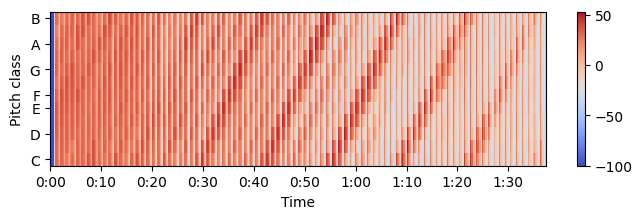

In [17]:
import librosa, librosa.display
C = librosa.feature.chroma_stft(y=x, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
plt.figure(figsize=(8, 2))
librosa.display.specshow(10 * np.log10(EPSILON + C), x_axis='time', 
                         y_axis='chroma', sr=Fs, hop_length=H)
plt.colorbar()
plt.show()